This notebook summarizes the theory and demonstration of using linear parameter varying (LPV) models to approximate the nonlinear dynamic response of OpenFAST.

The different steps involved, such as loading the linear models, setting up the interpolation scheme, and running a simulation, are shown.


For more information regarding the theory, please refer to:

[1] A. K. Sundarrajan, Y. H. Lee, J. T. Allison, D. S. Zalkind, D. R. Herber. 'Open-loop control co-design of semisubmersible floating offshore wind turbines using linear parameter-varying models.' (to appear) ASME Journal of Mechanical Design, 146(4), p. 041704, Apr 2024. doi: [https://doi.org/10.1115/1.4063969](https://doi.org/10.1115/1.4063969)

Please reach out to Athul.Sundarrajan@colostate.edu and Daniel.Herber@colostate.edu for more information and clarifications.

In [2]:
# import required packages
import numpy as np
import pickle
from mat4py import loadmat
from scipy.interpolate import interp1d,PchipInterpolator, CubicSpline, splprep, splev
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# Load linear model from the pickle file
pkl_file = 'ABCD_matrices.pkl'

# load pickle file
with open(pkl_file,'rb') as handle:
    linear_model = pickle.load(handle)
    
# the loaded linear_model is a list of dicts
linear_model = linear_model[0]

# Display quantities in the pickle file
print('The loaded linear_model dictionary contains the following fields:')
print('')
for key in linear_model.keys():
    print(key)
    print('')


The loaded linear_model dictionary contains the following fields:

sim_idx

A

B

C

D

x_ops

u_ops

y_ops

u_h

omega_rpm

DescCntrlInpt

DescStates

DescOutput

StateDerivOrder

ind_fast_inps

ind_fast_outs



In [4]:
# extract key quantities in dick

# extract linear models
Aw = linear_model['A']
Bw = linear_model['B']
Cw = linear_model['C']
Dw = linear_model['D']

x_ops = linear_model['x_ops']
u_ops = linear_model['u_ops']
y_ops = linear_model['y_ops']

ws = linear_model['u_h']

# print shape
np.shape(Aw)

(101, 101, 23)

In [5]:
# The goal is to interpolate the linear models on wind speed
# Therefore, the linear matrices must be reshaped into (nw,.,.)

Aw = np.transpose(Aw,(2,0,1))
Bw = np.transpose(Bw,(2,0,1))
Cw = np.transpose(Cw,(2,0,1))
Dw = np.transpose(Dw,(2,0,1))

# get shape
nw,nx,nu = np.shape(Bw)
ny = np.shape(Cw)[1]
print('nx : ' + str(nx))
print('nu : ' + str(nu))
print('ny : ' + str(ny))

# construct LPV models
# A matrix   
A_pp = PchipInterpolator(ws, Aw, axis = 0)
A_op = lambda w: A_pp(w)

# Bmatrix
B_pp = PchipInterpolator(ws, Bw, axis = 0)
B_op = lambda w: B_pp(w)

# Cmatrix
C_pp = PchipInterpolator(ws,Cw,axis = 0)
C_op = lambda w: C_pp(w)

# Dmatrix
D_pp = PchipInterpolator(ws,Dw,axis = 0)
D_op = lambda w: D_pp(w)

# control operating points
Uo_pp = PchipInterpolator(ws,u_ops,axis = 1)
Uo_fun = lambda w: Uo_pp(w)

# state operating points
Xo_pp = PchipInterpolator(ws, x_ops, axis = 1)
Xo_fun = lambda w: Xo_pp(w)

# outputs
Yo_pp = PchipInterpolator(ws, y_ops, axis = 1)
Yo_fun = lambda w: Yo_pp(w)

# first time derivative of state operating points
DXo_pp = Xo_pp.derivative 
DXo_pp = DXo_pp(nu=1)
DXo_fun = lambda w: DXo_pp(w)

nx : 101
nu : 3
ny : 269


In [6]:
# load OpenFAST simulation
pkl_file = 'step_NR.pkl'

with open(pkl_file,'rb') as handle:
    channels = pickle.load(handle)

# extract quantities
Time_OF = channels['Time']
nt = len(Time_OF)

controls_OF = np.zeros((nt,nu))

# convert units
for iu in range(nu):
        
        if iu == 0:
            # Wind1VelX
            controls_OF[:,iu] = np.array(channels['Wind1VelX'])
            
        elif iu == 1:
            # GenTq
            controls_OF[:,iu] = 1000*np.array(channels['GenTq'])
            
        elif iu == 2:
            # BldPitch
            controls_OF[:,iu] = np.array(np.deg2rad(channels['BldPitch1']))

# construct control function  
U_pp = PchipInterpolator(Time_OF, controls_OF ,axis = 0)
U_fun = lambda t: U_pp(t)
    
wind_speed = controls_OF[:,0]

Wavg = np.mean(wind_speed)

# DW, and DXoDt fun
W_pp = PchipInterpolator(Time_OF, wind_speed,axis = 0)
dW_pp = W_pp.derivative 
dW_pp = dW_pp(nu = 1)

DW_fun = lambda t: dW_pp(t)
W_fun = lambda t: W_pp(t)

DXoDt_fun = lambda t: DXo_fun(W_fun(t))*DW_fun(t)


In [7]:
def odefun(t,x,A_op,B_op,W_fun,U_fun,Uo_fun,DXoDt_fun,Wavg,caseflag):
    # static case
    if caseflag == 'LTI':
        w = Wavg
        
        A = A_op(w)
        B = B_op(w)
        u = U_fun(t)
        Uo = Uo_fun(w)
        
        dx = np.dot(A,x) + np.dot(B,(u-Uo))
        
    # LPV model  
    elif caseflag == 'LPV':
        w = W_fun(t)
        
        A = A_op(w)
        B = B_op(w)
        u = U_fun(t)
        Uo = Uo_fun(w)
        dXoDt = DXoDt_fun(t)
 
        xp = np.dot(A,x) + np.dot(B,(u-Uo))
        
        dx = np.squeeze(xp) - dXoDt
        
    return dx

In [8]:
# define simulation parameters
t0 = Time_OF[0]; tf = Time_OF[-1]

pp0 = np.deg2rad(channels['PtfmPitch'][0])
gs0 = (channels['GenSpeed'][0])/9.5492965964254

X0 = np.zeros((nx,))
X0[0] = pp0; X0[4] = gs0

# LTI case
caseflag = 'LTI'

# offset
X0_avg = X0 - Xo_fun(Wavg)

# solve
sol_s = solve_ivp(odefun,[t0,tf],X0_avg,method = 'RK45',args = (A_op,B_op,W_fun,U_fun,Uo_fun,DXoDt_fun,Wavg,caseflag),t_eval = Time_OF)
Time_LTI = sol_s.t
X_LTI = sol_s.y

Xoff_avg = Xo_fun(Wavg)
X_LTI = X_LTI.T + Xoff_avg 



In [9]:
# LPV model
caseflag = 'LPV'
X0_lpv = X0 - Xo_fun(W_fun(0))

# solve
sol = solve_ivp(odefun,[t0,tf],X0_lpv,method = 'RK45',args = (A_op,B_op,W_fun,U_fun,Uo_fun,DXoDt_fun,Wavg,caseflag),t_eval = Time_OF)

# extract solution
Time_LPV = sol.t
X_LPV = sol.y

# add the offset
Xoff = Xo_fun(W_fun(Time_LPV))
X_LPV = Xoff.T + X_LPV.T
    

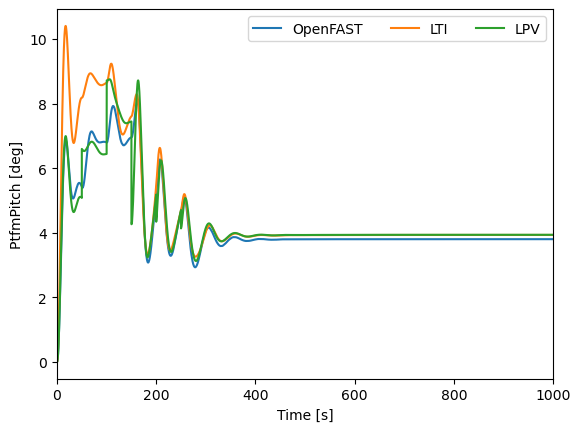

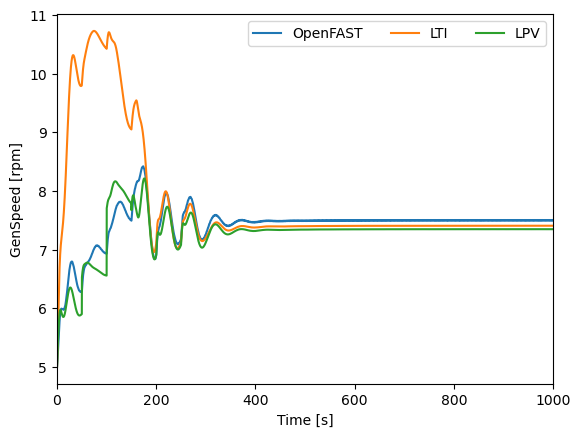

In [10]:
# plot
fig1,ax1 = plt.subplots(1)

ax1.plot(Time_OF,channels['PtfmPitch'],label = 'OpenFAST')
ax1.plot(Time_LTI,np.rad2deg(X_LTI[:,0]),label = 'LTI')
ax1.plot(Time_LPV,np.rad2deg(X_LPV[:,0]),label = 'LPV')
ax1.set_xlim([t0,tf])
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('PtfmPitch [deg]')
ax1.legend(ncol = 3)

# plot
fig2,ax2 = plt.subplots(1)

ax2.plot(Time_OF,channels['GenSpeed'],label = 'OpenFAST')
ax2.plot(Time_LTI,X_LTI[:,4]*9.5492965964254,label = 'LTI')
ax2.plot(Time_LPV,X_LPV[:,4]*9.5492965964254,label = 'LPV')
ax2.set_xlim([t0,tf])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('GenSpeed [rpm]')
ax2.legend(ncol = 3)